<a href="https://colab.research.google.com/github/jnunez03/SQL/blob/master/CookingAlerts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p><img alt="Colaboratory logo" height="45px" src="https://colab.research.google.com/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

<h1>Cooking Alerts</h1>

<h3>Subscriptions</h3> 

- Number of users being served a pay wall 
- Conversion from pay wall
   - Using either DSSOR or Thank You Events
- % of non-sub regi’s who are served a pay wall (DoW)
- How many Starts were created? (by DoW)
   - Using DSSOR
   
   


In [2]:
import pandas as pd
import pandas_profiling
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb
from pandas import Series, DataFrame
from pylab import *
import statsmodels.api as sm
from matplotlib.ticker import MaxNLocator
from matplotlib.font_manager import FontProperties
from scipy import stats
from scipy.stats import norm
from fbprophet import Prophet
import logging

logger = logging.getLogger('pandas_gbq')
logger.propagate = False 
logging.getLogger().disabled = True

#  Use ET2 From September Forward  -->  09/01 To  [current date - 1]
q = """
-- Paw Wall Impressions ET2
SELECT 
day,
format_datetime('%A',cast(day as datetime)) as dayName,
count(distinct users) as users,
count(distinct case when if_hit_paywall = 1 then users else null end) as hitpaywall,
count(distinct case when if_hit_paywall = 0 then users else null end) as didnot
FROM(
SELECT
DATE(p.timestamps.last_updated_dt_nyct) as day,
COALESCE(cast(p.json_kidd.user.regi_id as string),agent_id) as users,
MAX(CASE WHEN i.module.name LIKE '%paywall%' then 1 ELSE 0 END) as if_hit_paywall
FROM `nyt-eventtracker-prd.et.page` p   -- ET2 starts May 06
LEFT JOIN p.impressions i 
WHERE DATE(p._pt) BETWEEN '2019-09-01' and '2019-10-29'
AND LOWER(p.source_app) = 'nytcooking'
and (p.agent.browser.is_spider is null or agent.browser.is_spider = false)
GROUP BY 1,2
ORDER BY 1,2 ASC
)
GROUP BY 1 , 2
ORDER BY 1 ASC
LIMIT 58
"""

# importing the data
df = pd.read_gbq(q,
    project_id = 'nyt-bigquery-beta-workspace',
    dialect='standard')


# Descriptive statistics, data type, data preview 
print(df.describe(), ' \n \n', '*Data Types Below* \n \n', df.dtypes ,' \n \n', df.head(n=6))

INFO:google.auth.compute_engine._metadata:Compute Engine Metadata server unavailable.


Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=725825577420-unm2gnkiprugilg743tkbig250f4sfsj.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=YGDtkCBCHi78XUTIZDmoPpk4ZueLgm&prompt=consent&access_type=offline
Enter the authorization code: 4/sgHmbyszwoDlPubYHFyEUoq3ylqnJWtVjCw--zy4g5bu9c1ShXsBmBY
               users    hitpaywall         didnot
count      58.000000     58.000000      58.000000
mean   437169.810345  19813.017241  417356.793103
std     92922.206071   6683.654446   87369.263113
min    278035.000000  10123.000000  267739.000000
25%    365845.750000  14462.000000  349077.250000
50%    448529.000000  18612.500000  427978.000000
75%    501833.500000  24078.750000  473188.750000
max    660523.000000  39957.000000  623672.000000  
 
 *Data Types Below* 
 
 day           datetime64[ns]
dayName               object
u

In [0]:
# pandas_profiling.ProfileReport(df)


In [3]:
# make sure date is of datetime. 
df['day'] = pd.to_datetime(df['day'])
 
df.dtypes   

day           datetime64[ns]
dayName               object
users                  int64
hitpaywall             int64
didnot                 int64
dtype: object

In [0]:
# Assuming our users is proper denominator. 

df['PercentHitWall'] = df.apply(lambda row: (row.hitpaywall / row.users) * 100, axis=1)     # -- >  axis=1 or ‘columns’: apply function to each row.

In [5]:
df.head(n=58)    # index from 0

,day,dayName,users,hitpaywall,didnot,PercentHitWall
0,2019-09-01,Sunday,422207,18428,403779,4.364684
1,2019-09-02,Monday,474549,20591,453958,4.339067
2,2019-09-03,Tuesday,358711,17409,341302,4.853211
3,2019-09-04,Wednesday,395722,16523,379199,4.175406
4,2019-09-05,Thursday,280064,10123,269941,3.614531
5,2019-09-06,Friday,392731,13405,379326,3.413278
6,2019-09-07,Saturday,469414,28275,441139,6.023468
7,2019-09-08,Sunday,552990,21673,531317,3.919239
8,2019-09-09,Monday,495724,22431,473293,4.524897
9,2019-09-10,Tuesday,339581,12687,326894,3.736075


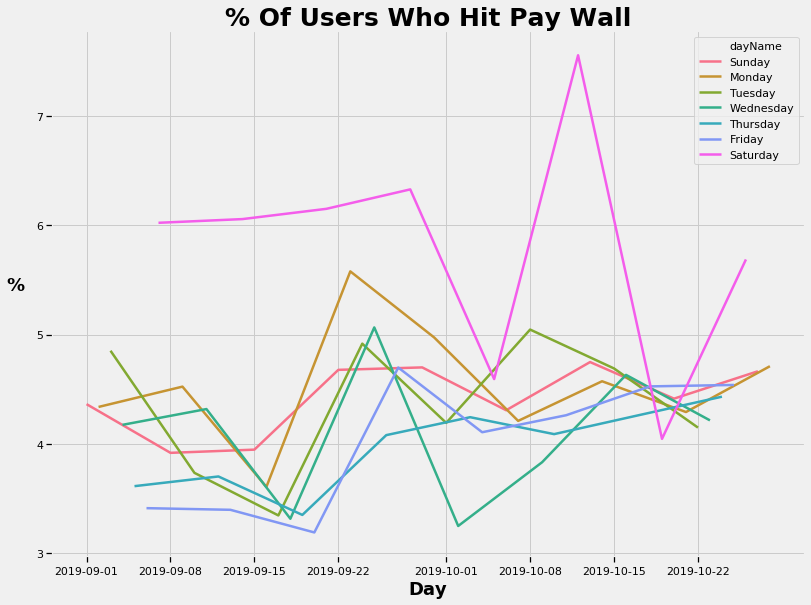

In [6]:
%matplotlib inline
plt.style.use('fivethirtyeight')
#plt.style.use('bmh')   #bmh, ggplot,seaborn-notebook,seaborn-deep,dark_background
rcParams['figure.figsize'] = 12,9

sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})
sb.lineplot(x="day", y="PercentHitWall", hue="dayName", data=df)   # Percent Hit WALL 
#sb.lineplot(x="day", y="hitpaywall", hue="dayName", data=df)   # Number Hit Wall 
plt.title('% Of Users Who Hit Pay Wall',fontsize=25,weight='bold')
plt.ylabel('%     ', fontsize=18, rotation=0, weight='bold')
plt.xlabel('Day',fontsize=18, weight='bold')
plt.show() 

In [0]:
dfMon = df[df['dayName'] == 'Monday']

dfTue = df[df['dayName'] == 'Tuesday']

dfWed = df[df['dayName'] == 'Wednesday']

dfThurs = df[df['dayName'] == 'Thursday']

dfFri =  df[df['dayName'] == 'Friday']

dfSat = df[df['dayName'] == 'Saturday']

dfSun = df[df['dayName'] == 'Sunday']

# Monday :) 


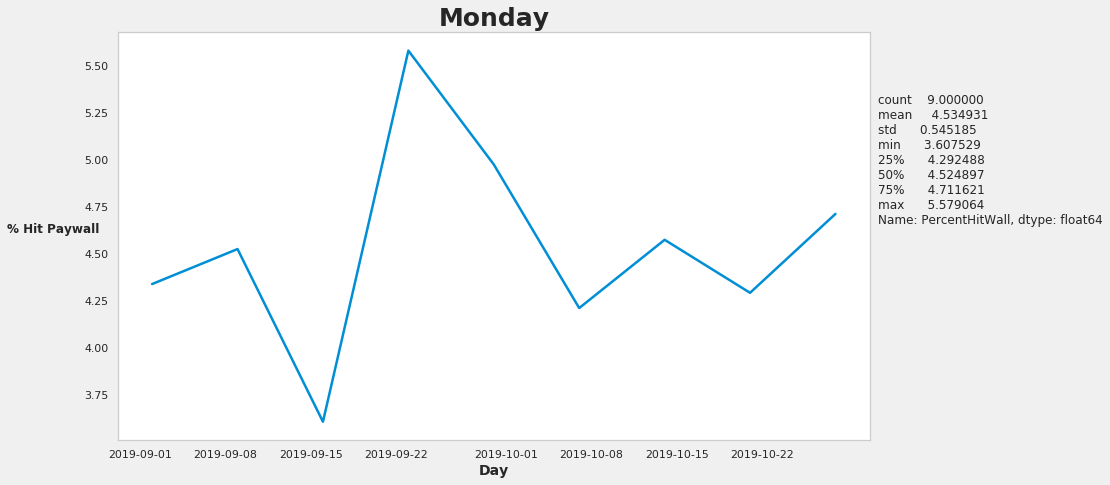

In [40]:
%matplotlib inline
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 12,7
sb.despine()
#sb.set(font_scale = .8)
sb.set_style("whitegrid", {'axes.grid' : False})
sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})

# dfMon
mon = dfMon["PercentHitWall"].describe()
mon1 = str(mon)

#dfMon
sb.lineplot(x="day", y="PercentHitWall",markers=True, dashes=False, data=dfMon)
plt.title('Monday',fontsize=25,weight='bold')
plt.ylabel('% Hit Paywall             ', fontsize=12, rotation=0, weight='bold')
plt.xlabel('Day',fontsize=14, weight='bold')
plt.figtext(.96, .5,mon1)
plt.show()

<h1> Tuesday  :) <h1> 
  

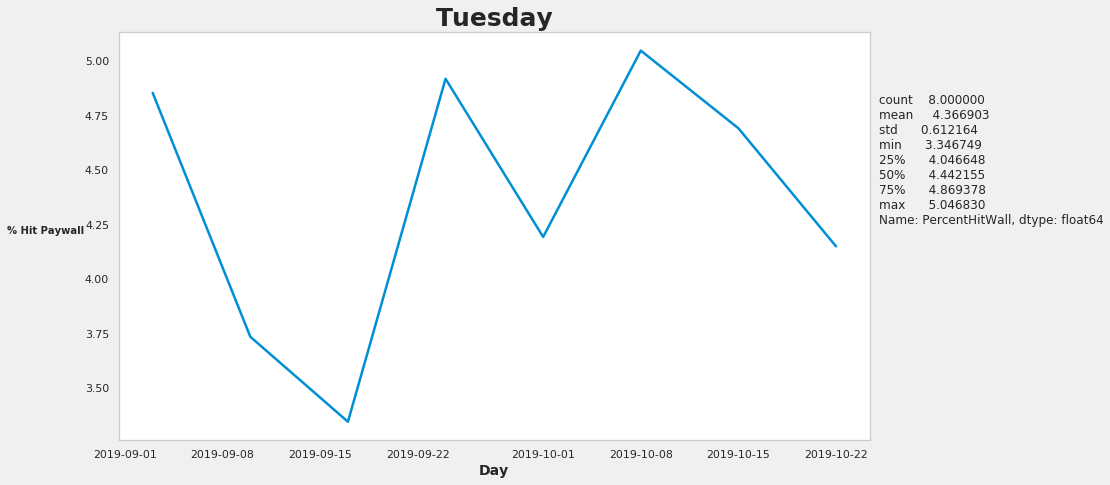

In [14]:
%matplotlib inline
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 12,7
sb.despine()
#sb.set(font_scale = .8)
sb.set_style("whitegrid", {'axes.grid' : False})
sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})

# dfTue
Tue = dfTue["PercentHitWall"].describe()
Tue1= str(Tue)

#dfTue
sb.lineplot(x="day", y="PercentHitWall", data=dfTue)
plt.title('Tuesday',fontsize=25,weight='bold')
plt.ylabel('% Hit Paywall                    ', fontsize=10, rotation=0, weight='bold')
plt.xlabel('Day',fontsize=14, weight='bold')
plt.figtext(.96, .5,Tue1)
plt.show()


<h1> Wednesday  :) <h1> 

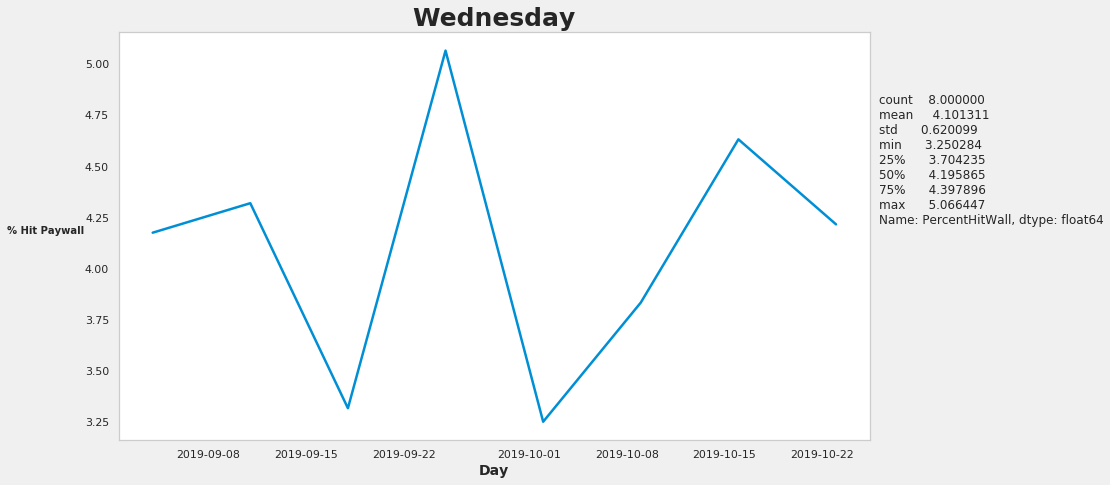

In [15]:
%matplotlib inline
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 12,7
sb.despine()
#sb.set(font_scale = .8)
sb.set_style("whitegrid", {'axes.grid' : False})
sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})

# dfWed
wed = dfWed["PercentHitWall"].describe()
wed1 = str(wed)

#dfWed
sb.lineplot(x="day", y="PercentHitWall", data=dfWed)
plt.title('Wednesday',fontsize=25,weight='bold')
plt.ylabel('% Hit Paywall                    ', fontsize=10, rotation=0, weight='bold')
plt.xlabel('Day',fontsize=14, weight='bold')
plt.figtext(.96, .5,wed1)
plt.show()

<h1> Thursday :) <h1> 

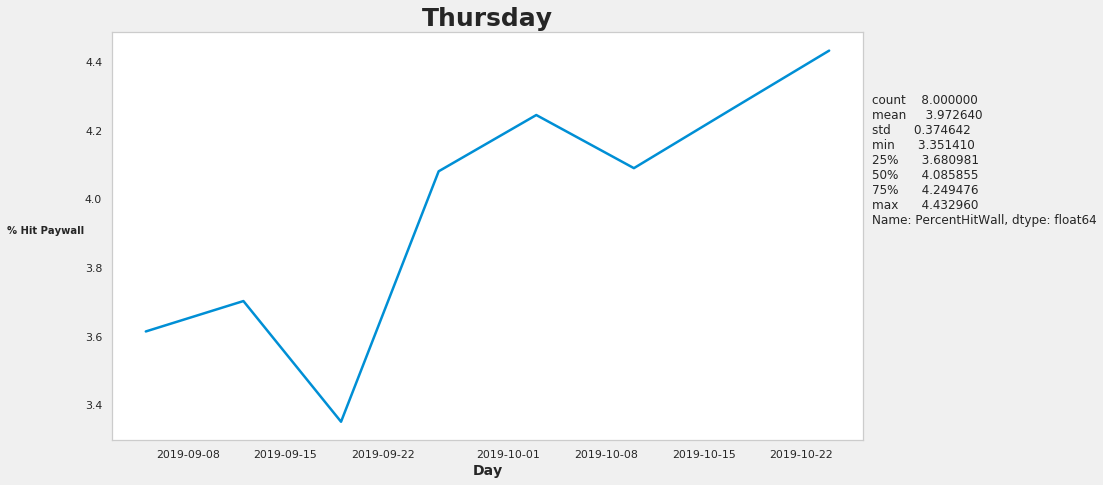

In [16]:
%matplotlib inline
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 12,7
sb.despine()
#sb.set(font_scale = .8)
sb.set_style("whitegrid", {'axes.grid' : False})
sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})

# dfThurs
thurs = dfThurs["PercentHitWall"].describe()
thurs1 = str(thurs)

# dfThurs
sb.lineplot(x="day", y="PercentHitWall", data=dfThurs)
plt.title('Thursday',fontsize=25,weight='bold')
plt.ylabel('% Hit Paywall                    ', fontsize=10, rotation=0, weight='bold')
plt.xlabel('Day',fontsize=14, weight='bold')
plt.figtext(.96, .5,thurs1)
plt.show()

<h1> Friday :) <h1> 

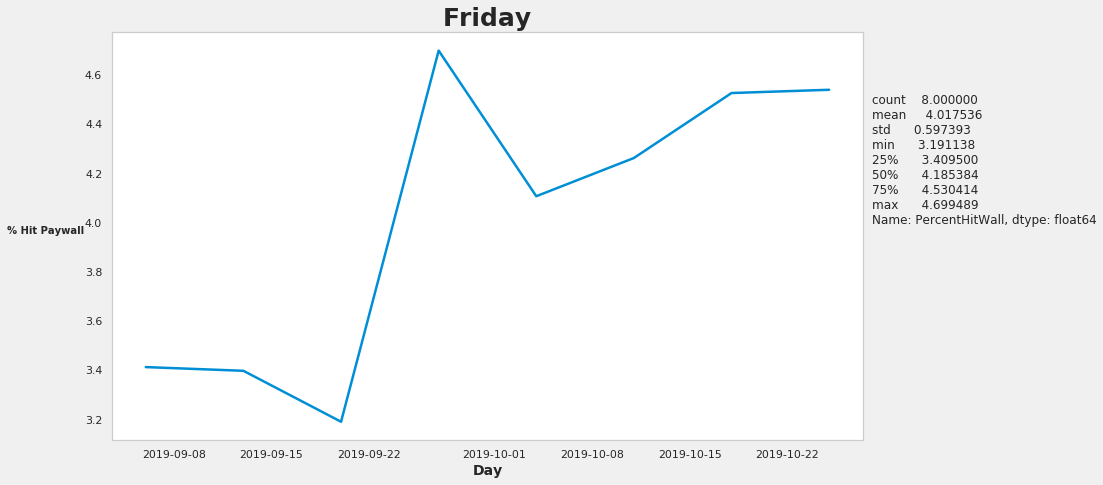

In [17]:
%matplotlib inline
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 12,7
sb.despine()
#sb.set(font_scale = .8)
sb.set_style("whitegrid", {'axes.grid' : False})
sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})

# dfFri
fri = dfFri["PercentHitWall"].describe()
fri1 = str(fri)

# dfFri
sb.lineplot(x="day", y="PercentHitWall", data=dfFri)
plt.title('Friday',fontsize=25,weight='bold')
plt.ylabel('% Hit Paywall                    ', fontsize=10, rotation=0, weight='bold')
plt.xlabel('Day',fontsize=14, weight='bold')
plt.figtext(.96, .5,fri1)
plt.show()

<h1> Saturday :) <h1> 

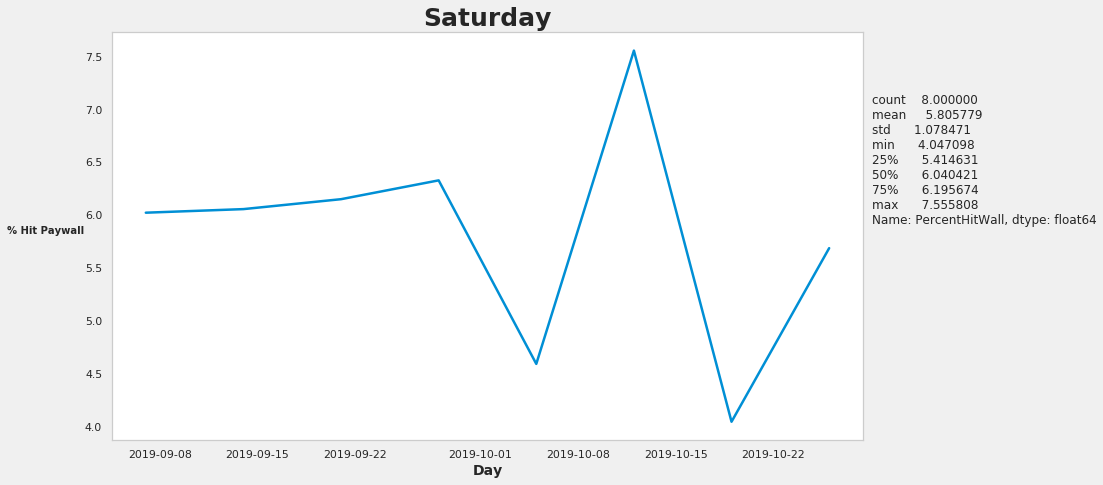

In [18]:
%matplotlib inline
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 12,7
sb.despine()
#sb.set(font_scale = .8)
sb.set_style("whitegrid", {'axes.grid' : False})
sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})

# dfSat
sat = dfSat["PercentHitWall"].describe()
sat1 = str(sat)

# dfSat
sb.lineplot(x="day", y="PercentHitWall", data=dfSat)
plt.title('Saturday',fontsize=25,weight='bold')
plt.ylabel('% Hit Paywall                    ', fontsize=10, rotation=0, weight='bold')
plt.xlabel('Day',fontsize=14, weight='bold')
plt.figtext(.96, .5,sat1)
plt.show()

<h1> Sunday :) <h1> 

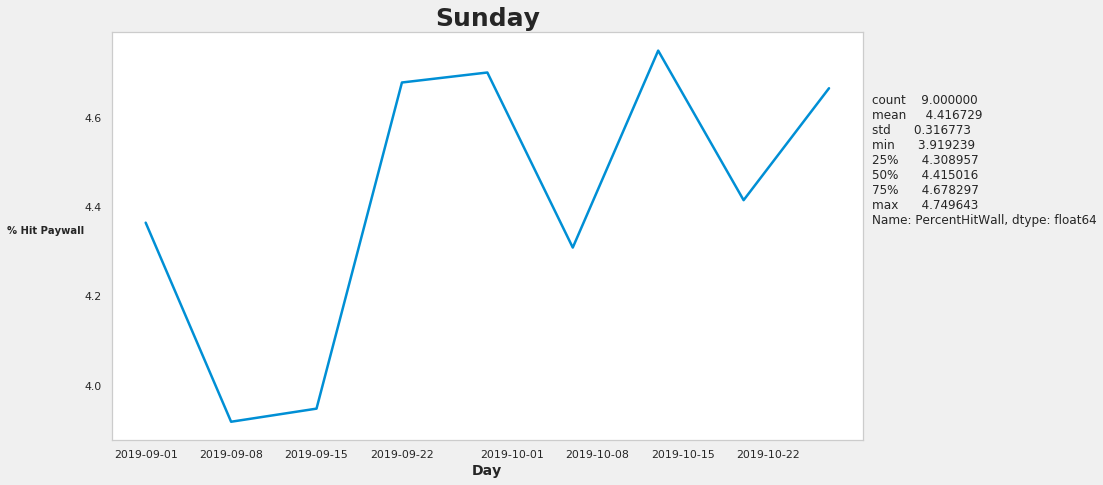

In [19]:
%matplotlib inline
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 12,7
sb.despine()
#sb.set(font_scale = .8)
sb.set_style("whitegrid", {'axes.grid' : False})
sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})

# dfSun
sun = dfSun["PercentHitWall"].describe()
sun1 = str(sun)

# dfSun
sb.lineplot(x="day", y="PercentHitWall", data=dfSun)
plt.title('Sunday',fontsize=25,weight='bold')
plt.ylabel('% Hit Paywall                    ', fontsize=10, rotation=0, weight='bold')
plt.xlabel('Day',fontsize=14, weight='bold')
plt.figtext(.96, .5,sun1)
plt.show()

In [0]:
#dfMon = df[df['dayName'] == 'Monday']
#dfTue = df[df['dayName'] == 'Tuesday']
#dfWed = df[df['dayName'] == 'Wednesday']
#dfThurs = df[df['dayName'] == 'Thursday']
#dfFri =  df[df['dayName'] == 'Friday']
#dfSat = df[df['dayName'] == 'Saturday']
#df[df['dayName'] == 'Sunday']["PercentHitWall"].describe()
print("\n")
print(df[df['dayName'] == 'Sunday']["PercentHitWall"].mean())
print("\n")
print(np.std(df[df['dayName'] == 'Sunday']["PercentHitWall"]))

MondayAverage = np.mean(df[df['dayName'] == 'Monday']["PercentHitWall"])
MondaySD= np.std(df[df['dayName'] == 'Monday']["PercentHitWall"])
Mondaylow, MondayHigh = ( MondayAverage - (2*(MondaySD)) ) , ( MondayAverage + (2*(MondaySD)))



print(MondayAverage, 'std-->', MondaySD)
print('\n')
print(Mondaylow, '', MondayHigh)

In [0]:
def ThresholdForAlerts(df):
  # Take each df segment and print the mean % hit paywall and interval
  
  # Monday
  MondayAverage = np.mean(df[df['dayName'] == 'Monday']["PercentHitWall"])
  MondaySD= np.std(df[df['dayName'] == 'Monday']["PercentHitWall"])
  Mondaylow, MondayHigh = ( MondayAverage - (2*(MondaySD)) ) , ( MondayAverage + (2*(MondaySD)))
  
  # Tuesday
  TuesdayAverage = np.mean(df[df['dayName'] == 'Tuesday']["PercentHitWall"])
  TuesdaySD = np.std(df[df['dayName'] == 'Tuesday']["PercentHitWall"])
  Tuesdaylow, TuesdayHigh = ( TuesdayAverage - (2*(TuesdaySD)) ) , ( TuesdayAverage + (2*(TuesdaySD)))
  
  # Wednesday
  WedAverage = np.mean(df[df['dayName'] == 'Wednesday']["PercentHitWall"])
  WedSD = np.std(df[df['dayName'] == 'Wednesday']["PercentHitWall"]) 
  Wedlow, WedHigh = ( WedAverage - (2*(WedSD)) ) , ( WedAverage + (2*(WedSD)))
  
  # Thursday
  ThursAverage = np.mean(df[df['dayName'] == 'Thursday']["PercentHitWall"])
  ThursSD = np.std(df[df['dayName'] == 'Thursday']["PercentHitWall"])
  Thurslow, ThursHigh = ( ThursAverage - (2*(ThursSD)) ) , ( ThursAverage + (2*(ThursSD)))
  
  # Friday
  FriAverage = np.mean(df[df['dayName'] == 'Friday']["PercentHitWall"])
  FriSD = np.std(df[df['dayName'] == 'Friday']["PercentHitWall"])
  Frilow, FriHigh = ( FriAverage - (2*(FriSD)) ) , ( FriAverage + (2*(FriSD)))
  
  # Saturday
  SatAverage = np.mean(df[df['dayName'] == 'Saturday']["PercentHitWall"])
  SatSD = np.std(df[df['dayName'] == 'Saturday']["PercentHitWall"])
  Satlow, SatHigh = ( SatAverage - (2*(SatSD)) ) , ( SatAverage + (2*(SatSD)))
  
  # Sunday
  SunAverage = np.mean(df[df['dayName'] == 'Sunday']["PercentHitWall"])
  SunSD = np.std(df[df['dayName'] == 'Sunday']["PercentHitWall"])
  Sunlow, SunHigh = ( SunAverage - (2*(SunSD)) ) , ( SunAverage + (2*(SunSD))) 
  
   
  return(print(' Monday Avg:', round(MondayAverage,3),
         '\n',
         'MondayLow - MondayHigh:', round(Mondaylow,3), '-', round(MondayHigh,3),
         '\n',
         '----------------------------------------------',
         '\n',
               
         'Tuesday Avg:', round(TuesdayAverage,3),
         '\n',
         'TuesdayLow - TuesdayHigh:', round(Tuesdaylow,3), '-', round(TuesdayHigh,3),
         '\n',
         '----------------------------------------------',
         '\n',
               
         'Wednesday Avg:', round(WedAverage,3),
         '\n',
         'WednesdayLow - WednesdayHigh:', round(Wedlow,3), '-', round(WedHigh,3),
         '\n',
         '----------------------------------------------',
         '\n',
               
         'Thursday Avg:', round(ThursAverage,3),
         '\n',
         'ThursdayLow - ThursdayHigh:', round(Thurslow,3), '-', round(ThursHigh,3),
         '\n',
         '----------------------------------------------',
         '\n',
               
         'Friday Avg:', round(FriAverage,3),
         '\n',
         'FridayLow - FridayHigh:', round(Frilow,3), '-', round(FriHigh,3),
         '\n',
         '----------------------------------------------',
         '\n',
               
         'Saturday Avg:', round(SatAverage,3),
         '\n',
         'SatLow - SatHigh:', round(Satlow,3), '-', round(SatHigh,3),
         '\n',
         '----------------------------------------------',
         '\n',
               
         'Sunday Avg:', round(SunAverage,3),
         '\n',
         'SunLow - SunHigh:', round(Sunlow,3), '-', round(SunHigh,3)
        ))  

In [1]:
ThresholdForAlerts(df)

NameError: ignored